In [64]:
import math

import snntorch as snn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List
from aes_commons import *
import random

In [65]:
config = {
    # Meta
    "no_epochs": 30,
    "batch_size" : 1000,
    # SNN config
    "num_steps": 50,
    "beta": 0.95,
    
    # Network dimentions
    "num_inputs": 1,
    "num_spiking1": 100,
    "num_spiking2": 100,
    "num_hidden_out": 100,
    "num_outputs": 1
}

In [66]:


def bytes_to_float_array(data_block:List[uint8])->List[float]:
    result : List[float] = []
    
    for id, byte in enumerate(data_block):
        input = bin(byte)
        input = input[2:]
        input = input[::-1]
        for _ in range(8):
            result.append(0.0)

        for i, bit in enumerate(input):
            result[id * 8 + i] = float(bit)
            
    return result
print(bytes_to_float_array({uint8(6)}))

@dataclass
class CryptoDataset:

    no_bytes: int # no of bytes in ciphered message
    batch_size: int
    n :int
    
    @staticmethod
    def from_size(no_bytes:int,batch_size:int):        
        return CryptoDataset(no_bytes=no_bytes,batch_size = batch_size)
        
    def __init__(self,  no_bytes:int, batch_size:int):
        self.no_bytes = no_bytes
        self.batch_size = batch_size
        self.n = 0
    
    def next_sub_byte(self):
        
        label : List[uint8] = []
        for _ in range(self.no_bytes) :
            label.append(uint8(random.randint(0,255)))
        
        input : List[uint8] = sub_bytes(label) 
        return (torch.FloatTensor(bytes_to_float_array(input)),torch.FloatTensor(bytes_to_float_array(label)))
    
    
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < self.batch_size:
            self.n += 1
            return self.next_sub_byte()
        else:
            raise StopIteration
    
    

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [67]:
from snntorch import spikegen

# spike_data = spikegen.rate(data_it, num_steps=num_steps)

In [68]:
class Model(nn.Module):
    def __init__(self):
        super().__init__();
        # Initialize layers
        self.fc0 = nn.Linear(config["num_inputs"], config["num_spiking1"])
        self.fc1 = nn.Linear(config["num_spiking1"], config["num_spiking2"])
        self.lif1 = snn.Leaky(beta=config["beta"])
        self.fc2 = nn.Linear(config["num_spiking2"], config["num_hidden_out"])
        self.lif2 = snn.Leaky(beta=config["beta"])
        
        self.fc3 = nn.Linear(config["num_hidden_out"], config["num_outputs"])
    
    def forward(self, x):
        # Initialize hidden state for each pass
        memory1 = self.lif1.init_leaky()
        memory2 = self.lif2.init_leaky()
        
        result_spikes = []
        result_membrain = []
        y = self.fc0(x)
        
        x = spikegen.rate(x, num_steps=config["num_steps"])
        
        spike_sum = torch.zeros(config["num_hidden_out"])
        for step in range(config["num_steps"]):
            cur1 = self.fc1(y)
            spikes1, memory1 = self.lif1(cur1, memory1)
            cur2 = self.fc2(spikes1)
            spikes2, memory2 = self.lif2(cur2, memory2)
            spike_sum += spikes2
        
        out = self.fc3(spike_sum)
        
        # Maybe another dense layer
        
        return out


In [69]:
net = Model()

In [70]:
from torch.utils.data import DataLoader
train_loader = CryptoDataset(2,config["batch_size"])
train_loader

CryptoDataset(no_bytes=2, batch_size=1000, n=0)

In [71]:
import snntorch.spikeplot as splt

# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data =spikegen.rate(data_it, num_steps=config["num_steps"])
spike_data.size()

AttributeError: 'builtin_function_or_method' object has no attribute 'randint'

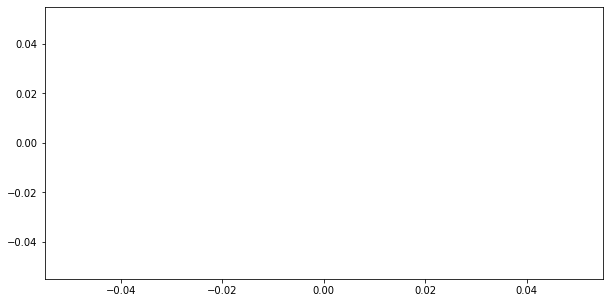

In [ ]:
spike_data = spike_data[:]
spike_data_sample_plot = spike_data.reshape((config["num_steps"], -1))
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample_plot, ax, s=1.5)

In [ ]:
loss_func = nn.MSELoss() # Idk
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
loss_hist = []

In [ ]:
for epoch in range(config["no_epochs"]):
    for batch_idx, (x, y) in enumerate(train_loader):
        net.train()
        
        # forward
        y = net(x)
        loss = loss_func(x, y)
        
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store loss history for future plotting
        loss_hist.append(loss.item())

RuntimeError: output with shape [100] doesn't match the broadcast shape [1, 100]

In [ ]:
plt.plot(loss_hist)

In [ ]:
net(torch.tensor([1], dtype=torch.float32))